In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from models import *
from typing import List
from data import SuperResolutionDataset
import torch.nn.functional as F
from i2sb.runner import Runner

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our Diffusion Layer is trained on a NAIP aerial imagery, which is 1m/pixel resolution imagery taken all over the US. It learns to map LR feature spaces of Sentinel-2 to the HR feature spaces of NAIP.

We now benchmark the trained Diffusion Layer's ability to map LR features spaces of Sentinel-2 to the HR feature spaces of 1mDrone from our Jamaica/Mexico expeditions.

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

Using Apple Metal Performance Shaders (MPS) device.



In [3]:
# opt.load variable. Path of checkpoint to load for net, ema, optimizer, sched
ckpt_path = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/results/test/model_001000.pt'
ckpt = torch.load(ckpt_path, map_location=DEVICE)
print(f"ckpt.keys()={ckpt.keys()}")

ckpt.keys()=dict_keys(['net', 'ema', 'optimizer', 'sched'])


In [4]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=1000,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=10001,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=ckpt_path,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"



In [5]:
torch.manual_seed(1234)

# setup DB latent
jamaica_dataset_drone = np.load('data/one_meter_drone/224latent_dataset_drone.npy', 'r')
jamaica_dataset_satellite = np.load('data/one_meter_drone/224latent_dataset_satellite.npy', 'r')
assert len(jamaica_dataset_drone) == len(jamaica_dataset_satellite), f"jamaica_dataset_drone b={jamaica_dataset_drone.shape[0]} and jamaica_dataset_satellite b={jamaica_dataset_satellite.shape[0]} don't have the same B"
print(f"jamaica_dataset_drone: {jamaica_dataset_drone.shape} | jamaica_dataset_satellite shape: {jamaica_dataset_satellite.shape}")

jamaica_clean_latent = torch.from_numpy(jamaica_dataset_drone).float()
jamaica_noisy_latent = torch.from_numpy(jamaica_dataset_satellite).float()
jamaica_dataset = SuperResolutionDataset(hr_images=jamaica_clean_latent, lr_images=jamaica_noisy_latent)
jamaica_loader = DataLoader(jamaica_dataset, batch_size=opt.microbatch, shuffle=True, drop_last=True)

# setup DA latent
naip_dataset_drone = np.load('data/one_meter_naip/224naip_latent_dataset_drone_V1.npy', 'r')
naip_dataset_satellite = np.load('data/one_meter_naip/224naip_latent_dataset_satellite_V1.npy', 'r')
assert len(naip_dataset_drone) == len(naip_dataset_satellite), f"naip_dataset_drone b={naip_dataset_drone.shape[0]} and naip_dataset_satellite b={naip_dataset_satellite.shape[0]} don't have the same B"
print(f"naip_dataset_drone: {naip_dataset_drone.shape} | naip_dataset_satellite shape: {naip_dataset_satellite.shape}")

naip_clean_latent = torch.from_numpy(naip_dataset_drone).float()
naip_noisy_latent = torch.from_numpy(naip_dataset_satellite).float()
naip_dataset = SuperResolutionDataset(hr_images=naip_clean_latent, lr_images=naip_noisy_latent)
naip_loader = DataLoader(naip_dataset, batch_size=opt.microbatch, shuffle=True, drop_last=True)

print(f"jamaica_loader of length {len(jamaica_loader)} and naip_loader of length {len(naip_loader)} created")

run = Runner(opt)

jamaica_dataset_drone: (584, 256, 14, 14) | jamaica_dataset_satellite shape: (584, 256, 14, 14)
naip_dataset_drone: (45540, 256, 14, 14) | naip_dataset_satellite shape: (45540, 256, 14, 14)
jamaica_loader of length 146 and naip_loader of length 11385 created


/var/folders/n5/g4x3txqs11v3ttxmdd3bdc8w0000gn/T/ipykernel_24529/942565751.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  jamaica_clean_latent = torch.from_numpy(jamaica_dataset_drone).float()


Loaded 'net' and 'ema' from checkpoint path
Built schrodinger_bridge Diffusion Model with 1000 steps and i2sb beta schedule!


In [6]:
# Benchmark model's noise prediction on DA(what the model is trained on) vs DB(unseen data)
total_naip_noise_pred_loss = 0
total_jamaica_noise_pred_loss = 0

num_iters = 100

run.net.eval()
with torch.no_grad():
  for n in range(num_iters):
    naip_x1, naip_x0 = next(iter(naip_loader))
    naip_x1, naip_x0 = naip_x1.to(DEVICE), naip_x0.to(DEVICE)

    jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE), jamaica_x0.to(DEVICE)

    step = torch.randint(0, opt.interval, (naip_x1.shape[0],)).to(opt.device) 
    naip_xt = run.diffusion.q_sample(step, naip_x0, naip_x1, ot_ode=opt.ot_ode).to(opt.device)
    jamaica_xt = run.diffusion.q_sample(step, jamaica_x0, jamaica_x1, ot_ode=opt.ot_ode).to(opt.device)

    naip_pred = run.net(naip_xt, diffuse=True, return_encoding_only=True, step=step, latent_input=True) # predicted noise
    naip_label = run.compute_label(step, naip_x0, naip_xt) # ground truth noise
    naip_noise_pred_loss = F.mse_loss(naip_pred, naip_label)
    total_naip_noise_pred_loss += naip_noise_pred_loss

    jamaica_pred = run.net(jamaica_xt, diffuse=True, return_encoding_only=True, step=step, latent_input=True) # predicted noise
    jamaica_label = run.compute_label(step, jamaica_x0, jamaica_xt) # ground truth noise
    jamaica_noise_pred_loss = F.mse_loss(jamaica_pred, jamaica_label)
    total_jamaica_noise_pred_loss += jamaica_noise_pred_loss

avg_naip_noise_pred_loss = total_naip_noise_pred_loss / num_iters
avg_jamaica_noise_pred_loss = total_jamaica_noise_pred_loss / num_iters

print(f"avg_naip_noise_pred_loss={avg_naip_noise_pred_loss} | avg_jamaica_noise_pred_loss={avg_jamaica_noise_pred_loss}")

avg_naip_noise_pred_loss=0.5022505521774292 | avg_jamaica_noise_pred_loss=0.5086538195610046


In [7]:
# Benchmark model's reconstruction on DA(what the model is trained on) vs DB(unseen data)
total_naip_reconstruction_loss = 0
total_jamaica_reconstruction_loss = 0

num_iters = 100

run.net.eval()
with torch.no_grad():
  for n in range(num_iters):
    naip_x1, naip_x0 = next(iter(naip_loader))
    naip_x1, naip_x0 = naip_x1.to(DEVICE), naip_x0.to(DEVICE)

    jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE), jamaica_x0.to(DEVICE)

    naip_xs, naip_pred_x0s = run.ddpm_sampling(opt, naip_x1, clip_denoise=opt.clip_denoise, verbose=False)
    naip_x0_hat = naip_pred_x0s[:, -1].to(opt.device)
    naip_reconstrution_loss = F.mse_loss(naip_x0_hat, naip_x0)
    total_naip_reconstruction_loss += naip_reconstrution_loss.item()

    jamaica_xs, jamaica_pred_x0s = run.ddpm_sampling(opt, jamaica_x1, clip_denoise=opt.clip_denoise, verbose=False)
    jamaica_x0_hat = jamaica_pred_x0s[:, -1].to(opt.device)
    jamaica_reconstrution_loss = F.mse_loss(jamaica_x0_hat, jamaica_x0)
    total_jamaica_reconstruction_loss += jamaica_reconstrution_loss.item()

avg_naip_reconstruction_loss = total_naip_reconstruction_loss / num_iters
avg_jamaica_reconstruction_loss = total_jamaica_reconstruction_loss / num_iters

print(f"avg_naip_reconstruction_loss={avg_naip_reconstruction_loss} | avg_jamaica_reconstruction_loss={avg_jamaica_reconstruction_loss}")

avg_naip_reconstruction_loss=0.0031034977734088896 | avg_jamaica_reconstruction_loss=0.004855702123604715


naip_loss_per_step: [0.0032030148431658745, 0.01430530659854412, 0.02707885392010212, 0.04186020419001579, 0.058746591210365295, 0.07736741751432419, 0.09406251460313797, 0.1091928631067276, 0.12195871025323868, 0.1319233477115631]
jamaica_loss_per_step: [0.004570621065795422, 0.01560975331813097, 0.028411438688635826, 0.043350957334041595, 0.06018243730068207, 0.07858064025640488, 0.095448337495327, 0.11023906618356705, 0.12307269126176834, 0.1329537332057953]


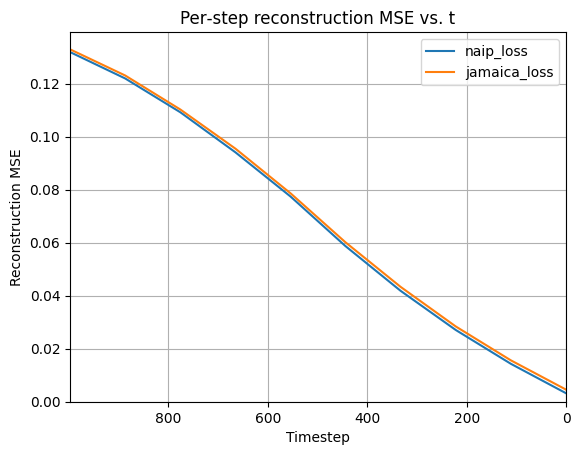

In [11]:
# plot x0_preds loss curve over entire trajectory of 1 microbatch

run.net.eval()
with torch.no_grad():
  naip_x1, naip_x0 = next(iter(naip_loader))
  naip_x1, naip_x0 = naip_x1.to(DEVICE), naip_x0.to(DEVICE)

  jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
  jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE), jamaica_x0.to(DEVICE)

  naip_xs, naip_pred_x0s = run.ddpm_sampling(opt, naip_x1, clip_denoise=opt.clip_denoise, verbose=False)
  naip_pred_x0s = naip_pred_x0s.to(opt.device)

  jamaica_xs, jamaica_pred_x0s = run.ddpm_sampling(opt, jamaica_x1, clip_denoise=opt.clip_denoise, verbose=False)
  jamaica_pred_x0s = jamaica_pred_x0s.to(opt.device)

B, numSteps, C, H, W = naip_pred_x0s.shape
naip_loss_per_step = []
jamaica_loss_per_step = []

for s in range(numSteps):
  # pred_x0s[:,s] is (B, C, H, W)
  naip_reconstruction_loss = F.mse_loss(naip_pred_x0s[:,s], naip_x0)
  jamaica_reconstruction_loss = F.mse_loss(jamaica_pred_x0s[:,s], jamaica_x0)
  naip_loss_per_step.append(naip_reconstruction_loss.item())
  jamaica_loss_per_step.append(jamaica_reconstruction_loss.item())

log_steps = [0, 111, 222, 333, 444, 554, 665, 776, 887, 998] # hardcoded - based on opt.interval and log_count
naip_loss_per_step.reverse()
jamaica_loss_per_step.reverse()

print(f"naip_loss_per_step: {naip_loss_per_step}")
print(f"jamaica_loss_per_step: {jamaica_loss_per_step}")

plt.figure()
plt.gca().invert_xaxis()
plt.plot(log_steps, naip_loss_per_step, label="naip_loss")
plt.plot(log_steps, jamaica_loss_per_step, label="jamaica_loss")
plt.legend(loc="upper right")
plt.xlabel("Timestep")
plt.ylabel("Reconstruction MSE")
plt.xlim(log_steps[-1], log_steps[0])
plt.ylim(0)
plt.title("Per‐step reconstruction MSE vs. t")
plt.grid(True)
plt.show()